## Imports

In [1]:
## Uncomment only on colab
# !pip install transformers evaluate
# !git clone https://github.com/DanielSc4/Approach-LWD.git
# %cd Approach-LWD/src

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# from torch.utils.data import Dataset
from models.CustomDatasetBinary import CustomDatasetBinary
from torch.utils.data import DataLoader

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
### models_name = 'bert-base-uncased'

### BERT
# models_name = 'bert-base-uncased'
### RoBERTa
model_name = 'roberta-base'
torch_dtype = torch.float32

In [5]:
# selecting device based on whats available
device = ''
if torch.cuda.is_available():
    print('Using GPU')
    device = 'cuda'
# Only on torch night for Apple M1 GPU
elif torch.backends.mps.is_available():
    print('Using MPS (Apple Silicon GPU)')
    device = 'mps'
else:
    print('Using CPU, :(')
    device = 'cpu'

Using MPS (Apple Silicon GPU)


## Datasets & loaders

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# starting w/ MD dataset
df = pd.read_csv('../data/MD_LoD.csv', index_col = 0)
df

# exclude labels == 2 (slightly agreement)
df = df[df['disagreement_lev'] != 2]
# shuffle dataser
df = df.sample(frac=1)


BATCH_SIZE = 22

train_set = CustomDatasetBinary(df[df['split'] == 'train'], tokenizer, label_col = 'disagreement_lev', dtype = torch_dtype)
val_set = CustomDatasetBinary(df[df['split'] == 'dev'], tokenizer, label_col = 'disagreement_lev', dtype = torch_dtype)
test_set = CustomDatasetBinary(df[df['split'] == 'test'], tokenizer, label_col = 'disagreement_lev', dtype = torch_dtype)


# ############ only to overfit a batch (test to check model's correctness)
# fake_df = pd.concat(
#     [df[:BATCH_SIZE]] * 1   # concat the same batch multiple times
# )
# train_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# val_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# test_set = CustomDatasetBinary(fake_df, tokenizer, label_col = 'disagreement_lev')
# print(f'----------\n|-> Using fake_df: size {len(fake_df)}\n----------')
# print(f'Label distr: \n{fake_df["disagreement_lev"].value_counts()}\n')
# ############ comment this section to train on the entire data available


print(f'len: \n\tTrain: {len(train_set)}\n\tVal: {len(val_set)}\n\tTest: {len(test_set)}')

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

len: 
	Train: 4662
	Val: 787
	Test: 2148


### Second take
Eseguo il fine tune solo sui dati senza disagreement (```soft``` == 0 | 1 oppure ```disagreement_lev``` == 0)

In [8]:
# REDO for custom training and fine-tune based on hard label, only where there is no disagreement
train_set = CustomDatasetBinary(
    df[(df['split'] == 'train') & (df['disagreement_lev'] == 0)], 
    tokenizer, label_col = 'hard_label', dtype = torch_dtype
)
val_set = CustomDatasetBinary(
    df[(df['split'] == 'dev') & (df['disagreement_lev'] == 0)],  
    tokenizer, label_col = 'hard_label', dtype = torch_dtype
)
test_set = CustomDatasetBinary(
    df[(df['split'] == 'test') & (df['disagreement_lev'] == 0)], 
    tokenizer, label_col = 'hard_label', dtype = torch_dtype
)

print(f'len: \n\tTrain: {len(train_set)}\n\tVal: {len(val_set)}\n\tTest: {len(test_set)}')

train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

len: 
	Train: 2778
	Val: 465
	Test: 1292


## Model from Hugging Face 
### (update for hate classificaiton and only agreement)

In [9]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

df_agr_train = df[(df['split'] == 'train') & (df['disagreement_lev'] == 0)]
df_agr_val = df[(df['split'] == 'dev') & (df['disagreement_lev'] == 0)]
df_agr_test = df[(df['split'] == 'test') & (df['disagreement_lev'] == 0)]

# componing dataset
d = {
    'train': Dataset.from_dict({'label': df_agr_train['hard_label'], 'text': df_agr_train['text']}),
    'val': Dataset.from_dict({'label': df_agr_val['hard_label'], 'text': df_agr_val['text']}),
    'test': Dataset.from_dict({'label': df_agr_test['hard_label'], 'text': df_agr_test['text']}),
}

d = DatasetDict(d)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length = 256, truncation=True)

tokenized_datasets = d.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["val"].shuffle(seed=42)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/2778 [00:00<?, ? examples/s]

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

Map:   0%|          | 0/1292 [00:00<?, ? examples/s]

In [10]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset= small_train_dataset,
    eval_dataset= small_eval_dataset,
    compute_metrics = compute_metrics,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [29]:
trainer.train()

/Users/daniel/miniforge3/envs/torch_new/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1749 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
trainer.evaluate(tokenized_datasets["test"].shuffle(seed=42))

  0%|          | 0/269 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Getting TSNE after PCA

In [71]:
# get tokenized test dataset
input_ids = tokenizer(['example', 'sentence'], padding = 'max_length', max_length = 40, return_tensors='pt')
# get embedding(s)
outputs = model.roberta(**input_ids, output_hidden_states = True)
# get fine-tuned embedding(s)
outputs[0][:, 0, :]       # take <s> token (equiv. to [CLS])

torch.Size([2, 768])

In [168]:
def get_emb(loader):
    embeddings = []
    lbs = []
    for inputs, labels in tqdm(loader):
        for ele in inputs:
                inputs[ele] = inputs[ele].to(device)
        with torch.no_grad():
            out = model.roberta(
                inputs['input_ids'],
                inputs['attention_mask'],
                return_dict = False,
            )
            pooled_output = out[0][:, 0, :]       # take <s> token (equiv. to [CLS])
        embeddings.extend(pooled_output.detach().cpu().numpy().tolist())
        lbs.extend(labels.double().detach().cpu().numpy())
    return embeddings, lbs

model.to(device)
embeddings_for_pca, labels_for_pca = get_emb(test_loader)

100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


In [169]:
#### Get additional embedding from disagreement
# select a row where there is disagreement
tmp_df = df[df['soft_label'] == "{'0': 0.6000000000000001, '1': 0.4}"]
tmp_df[tmp_df['split'] == 'test'].iloc[0]
# get the embedding
input_disagreement = (tokenizer(tmp_df[tmp_df['split'] == 'test'].iloc[0]['text'], padding="max_length", max_length = 2, truncation=True, return_tensors='pt'), torch.tensor([2.0]))

disa_emb_pca, disa_lbl_pca = get_emb([input_disagreement])
disa_emb_pca = disa_emb_pca[0]
disa_lbl_pca = disa_lbl_pca[0]

# append to the end of all embeddings with its label
embeddings_for_pca.append(disa_emb_pca)
labels_for_pca.append(disa_lbl_pca)

100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Explained variation per principal component: [0.37, 0.04, 0.04, 0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01]
aka 58.4 %
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1293 samples in 0.001s...
[t-SNE] Computed neighbors for 1293 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1293
[t-SNE] Computed conditional probabilities for sample 1293 / 1293
[t-SNE] Mean sigma: 0.047209
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.396080
[t-SNE] KL divergence after 300 iterations: 2.401740


/var/folders/dm/hdzllcns3zdb5jmhx96_ljr00000gn/T/ipykernel_89988/3939862841.py:29: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


<Axes: title={'center': 'Embeddings on hate speech (only agreement)'}, xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

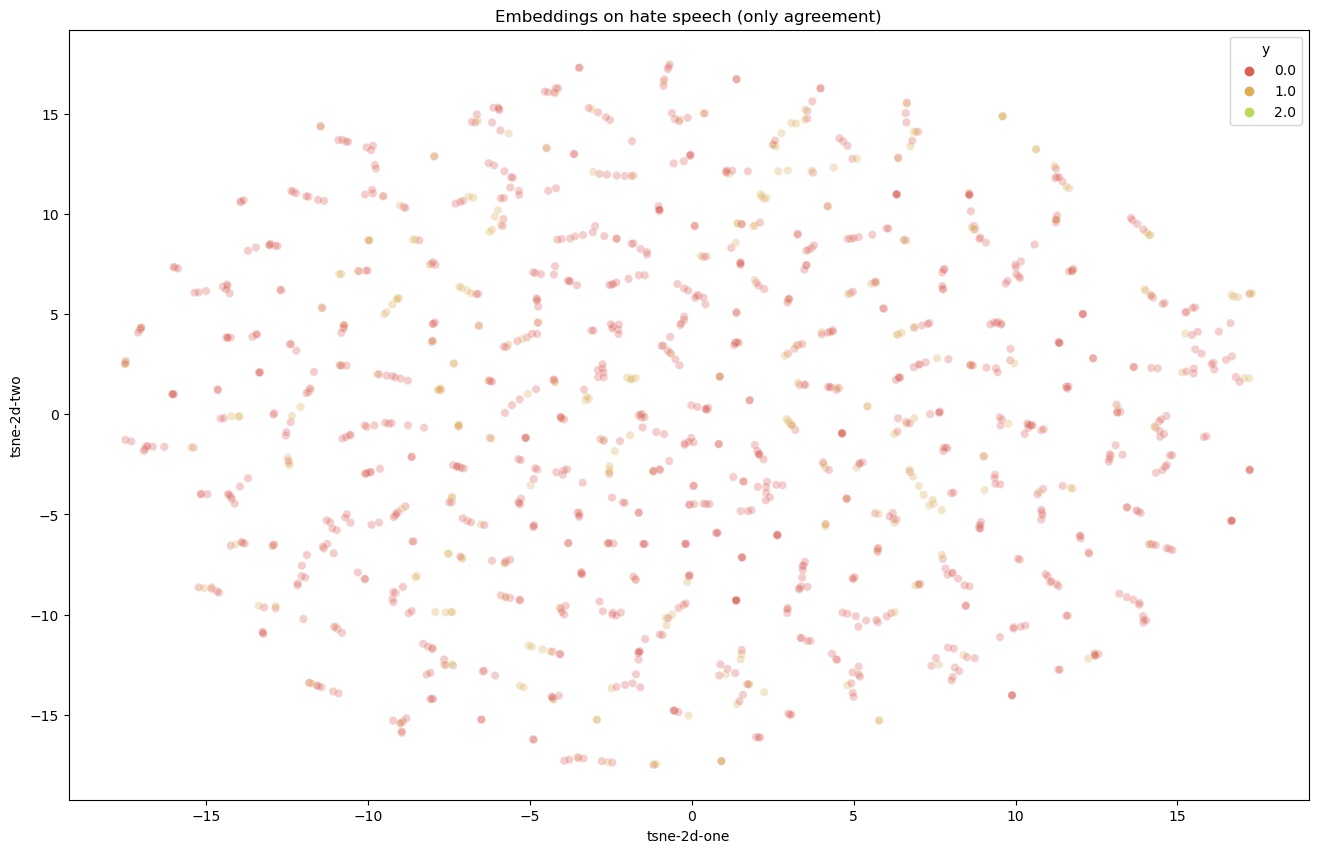

In [170]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca_result = pca.fit_transform(embeddings_for_pca)

print('Explained variation per principal component: {}'.format([round(ele, 2) for ele in pca.explained_variance_ratio_]))
print(f'aka {round(sum(pca.explained_variance_ratio_), 3) * 100} %')


# TSNE on 
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 2, n_iter = 300)
tsne_results = tsne.fit_transform(np.array(pca_result))

one_dim = tsne_results[:,0]
two_dim = tsne_results[:,1]

data_tsne = pd.DataFrame.from_dict({
    'tsne-2d-one': one_dim,
    'tsne-2d-two': two_dim,
    'y': labels_for_pca,
})


import seaborn as sns

plt.figure(figsize=(16,10))
plt.title('Embeddings on hate speech (only agreement)')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data = data_tsne,
    legend="full",
    alpha=0.3
)

## Model

In [42]:
from models.TransformerBinaryClassifier import TransformerBinaryClassifier

from transformers import AutoModel
transformer_model = AutoModel.from_pretrained(model_name, torch_dtype = torch_dtype)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# test
tokenizer(
    ['hello my name is Daniel', 'hello my name is Roberta'],
    padding = 'max_length', 
    max_length = 20, 
    truncation = True,
    return_tensors = "pt",
)

{'input_ids': tensor([[    0, 42891,   127,   766,    16,  3028,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 42891,   127,   766,    16,  1738,   102,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [8]:
# input of the model: 
#   input_ids
#   attention_mask
model = TransformerBinaryClassifier(
    model = transformer_model,
    dropout_rate = .0,
)
# inp, lbl = next(iter(train_loader))
# out = model(
#     inp['input_ids'],
#     inp['attention_mask'],
# )
# print(out.shape)
# out.reshape(len(out)).shape


In [9]:
from models.utils import train_loop
import torch.nn as nn

from torch.optim import Adam
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 3e-3)

history = train_loop(
    epochs = 6, 
    model = model, 
    device = device, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    optimizer = optimizer, 
    criterion = criterion,
    log_freq = len(train_loader) // 10, 
    dtype = torch_dtype,
    name = 'test2',
)

-- Epoch 01 --
tensor([0.5032, 0.5018, 0.5049, 0.5009, 0.5027, 0.5031, 0.5003, 0.4960, 0.5004,
        0.5003, 0.5039], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
   01) [train,     1] 	loss: 0.694
tensor([0.4765, 0.4952, 0.4907, 0.4663, 0.4743, 0.4619, 0.4593, 0.4986, 0.4453,
        0.4810, 0.4486], device='mps:0')
   01) [eval,     1] 	loss: 0.662
   [Recap 01 epoch] - train_loss: 0.694, train_acc: 0.3636 | eval_loss: 0.662, eval_acc: 0.5455 | elapsed time: 1.6s	 <-- Best epoch so far, val	 <-- Best epoch so far, acc

-- Epoch 02 --
tensor([0.4824, 0.4982, 0.4916, 0.4675, 0.4834, 0.4741, 0.3506, 0.4958, 0.3399,
        0.4873, 0.4570], device='mps:0', grad_fn=<ReshapeAliasBackward0>)
   02) [train,     1] 	loss: 0.631
tensor([0.4438, 0.4933, 0.4840, 0.3762, 0.4507, 0.4036, 0.3754, 0.4980, 0.3604,
        0.4676, 0.3657], device='mps:0')
   02) [eval,     1] 	loss: 0.603
   [Recap 02 epoch] - train_loss: 0.631, train_acc: 0.5455 | eval_loss: 0.603, eval_acc: 0.5455 | elapsed ti

### Plot

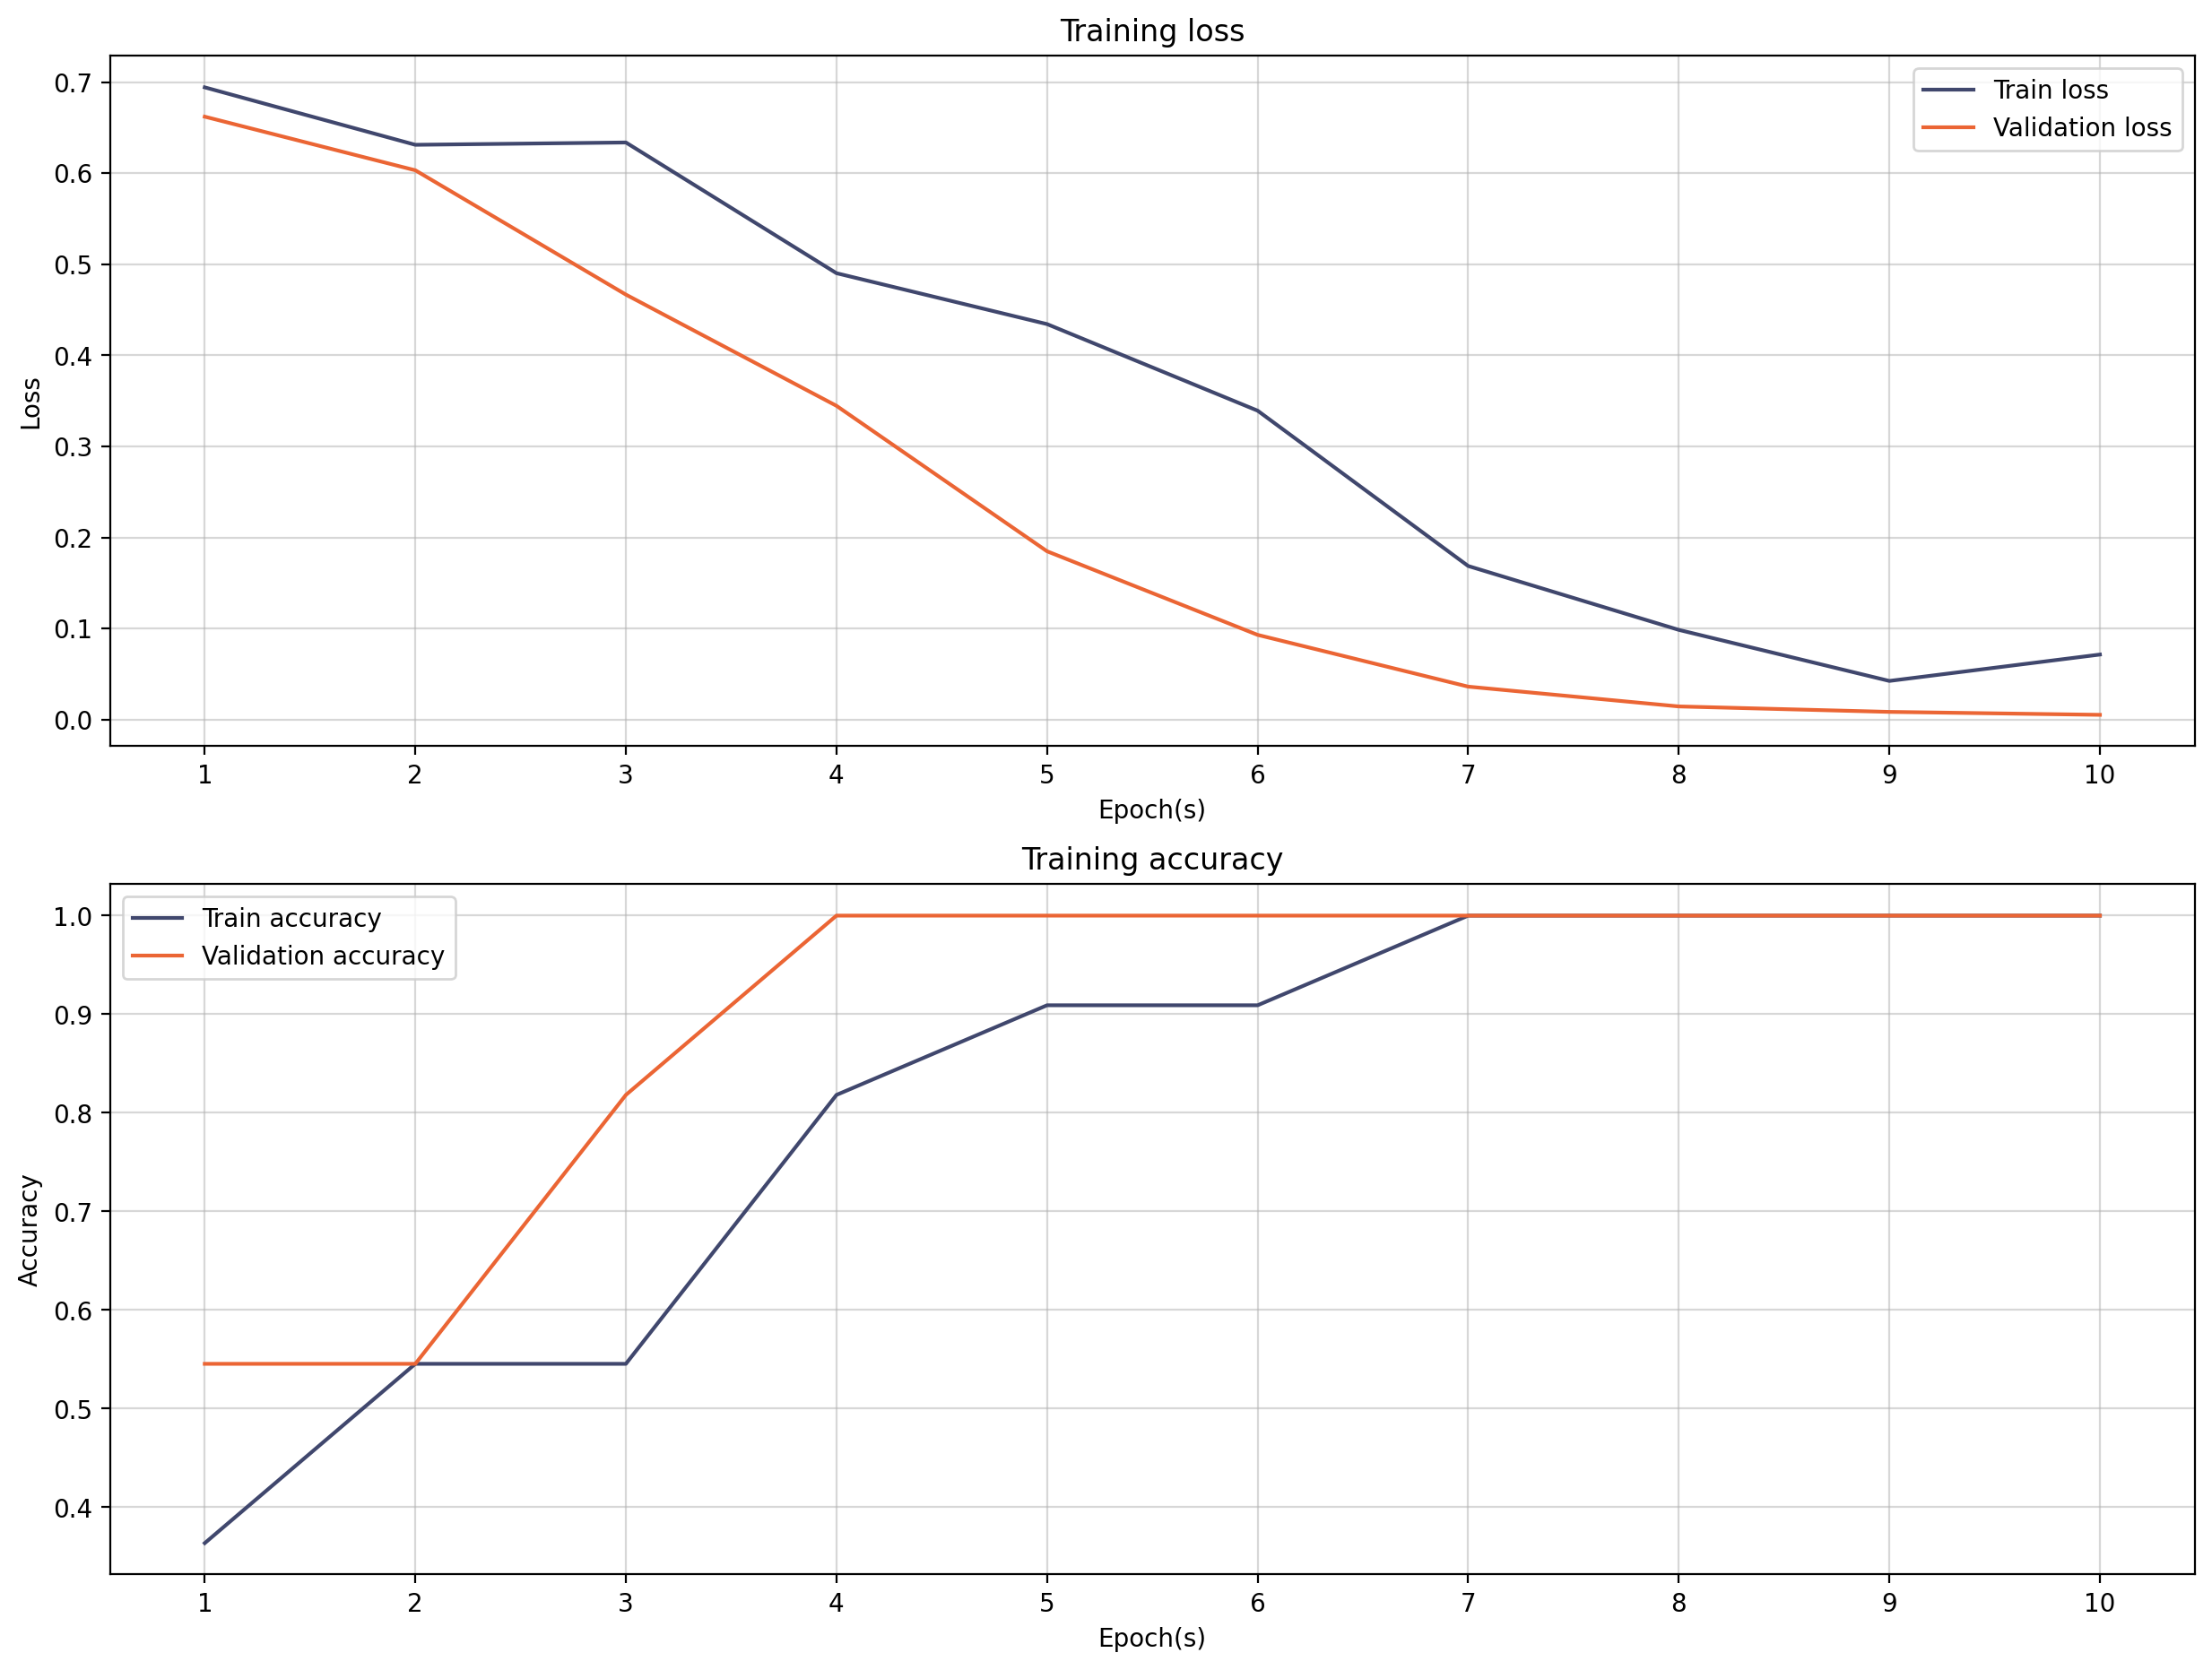

In [11]:
palette = {
    0: '#ACBEA3', 
    1: '#40476D', 
    2: '#826754', 
    3: '#EB6534',
    4: '#AD5D4E'
}
plt.figure(figsize= (15, 11), dpi = 200)

plt.subplot(2, 1, 1)
x = np.arange(len(history['train_losses'])) + 1
plt.xticks(x)
plt.plot(x, history['train_losses'], label = 'Train loss', color = palette[1])
plt.plot(x, history['val_losses'], label = 'Validation loss', color = palette[3])
plt.title('Training loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.grid(alpha = .5)
plt.legend()

plt.subplot(2, 1, 2)
plt.xticks(x)
plt.plot(x, history['train_accs'], label = 'Train accuracy', color = palette[1])
plt.plot(x, history['val_accs'], label = 'Validation accuracy', color = palette[3])
plt.title('Training accuracy')
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
plt.grid(alpha = .5)
plt.legend()

plt.show()

In [12]:
# tmp store
import pickle
with open('backup_history1.pkl', 'wb') as f:
    pickle.dump(history, f)

## Only get embeddings

In [162]:
transformer_model = transformer_model.to(device)
transformer_model.eval()

embeddings = []

def get_emb(loader):
    embeddings = []
    lbs = []
    for inputs, labels in tqdm(loader):
        for ele in inputs:
                inputs[ele] = inputs[ele].to(device)
        with torch.no_grad():
            _, pooled_output = transformer_model(
                inputs['input_ids'],
                inputs['attention_mask'],
                return_dict = False,
            )
        embeddings.extend(pooled_output.detach().cpu().numpy().tolist())
        lbs.extend(labels.double().detach().cpu().numpy())
    return embeddings, lbs

embeddings_train, labels_train = get_emb(train_loader)

100%|██████████| 127/127 [00:54<00:00,  2.32it/s]


In [163]:
embeddings_val, labels_val = get_emb(val_loader)
embeddings_test, labels_test = get_emb(test_loader)

100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


Explained variation per principal component: [0.36, 0.05, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01]
aka 58.4 %
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2778 samples in 0.001s...
[t-SNE] Computed neighbors for 2778 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2778
[t-SNE] Computed conditional probabilities for sample 2000 / 2778
[t-SNE] Computed conditional probabilities for sample 2778 / 2778
[t-SNE] Mean sigma: 0.022946
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.467911
[t-SNE] KL divergence after 300 iterations: 3.457014


/var/folders/dm/hdzllcns3zdb5jmhx96_ljr00000gn/T/ipykernel_43895/2694938890.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

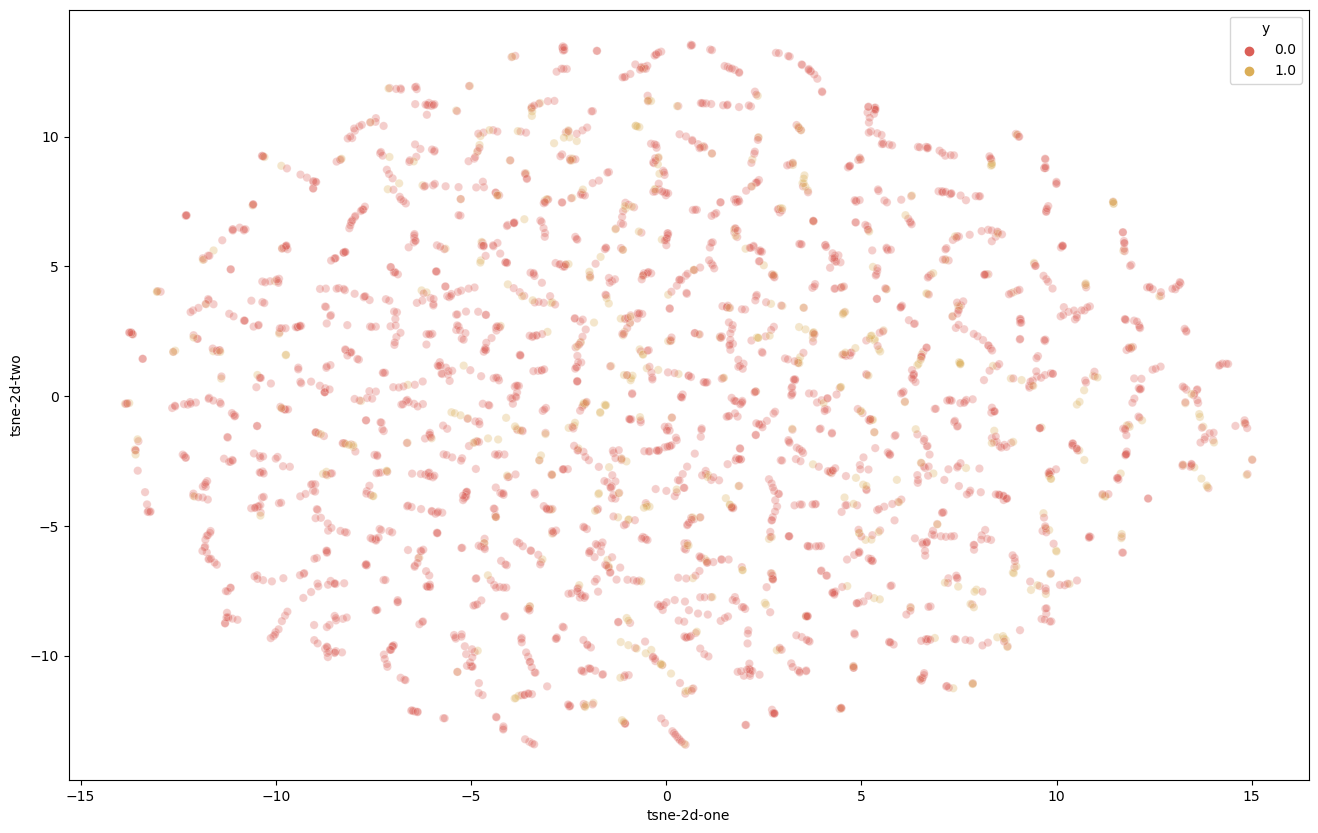

In [167]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca_result = pca.fit_transform(embeddings_train)

print('Explained variation per principal component: {}'.format([round(ele, 2) for ele in pca.explained_variance_ratio_]))
print(f'aka {round(sum(pca.explained_variance_ratio_), 3) * 100} %')


# TSNE on 
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 2, n_iter = 300)
tsne_results = tsne.fit_transform(np.array(pca_result))

one_dim = tsne_results[:,0]
two_dim = tsne_results[:,1]

data_tsne = pd.DataFrame.from_dict({
    'tsne-2d-one': one_dim,
    'tsne-2d-two': two_dim,
    'y': labels_train,
})

import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data = data_tsne,
    legend="full",
    alpha=0.3
)

Explained variation per principal component: [0.36, 0.05, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01]
aka 58.4 %
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2778 samples in 0.001s...
[t-SNE] Computed neighbors for 2778 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2778
[t-SNE] Computed conditional probabilities for sample 2000 / 2778
[t-SNE] Computed conditional probabilities for sample 2778 / 2778
[t-SNE] Mean sigma: 0.022869
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.252296


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[t-SNE] KL divergence after 300 iterations: 2.918186


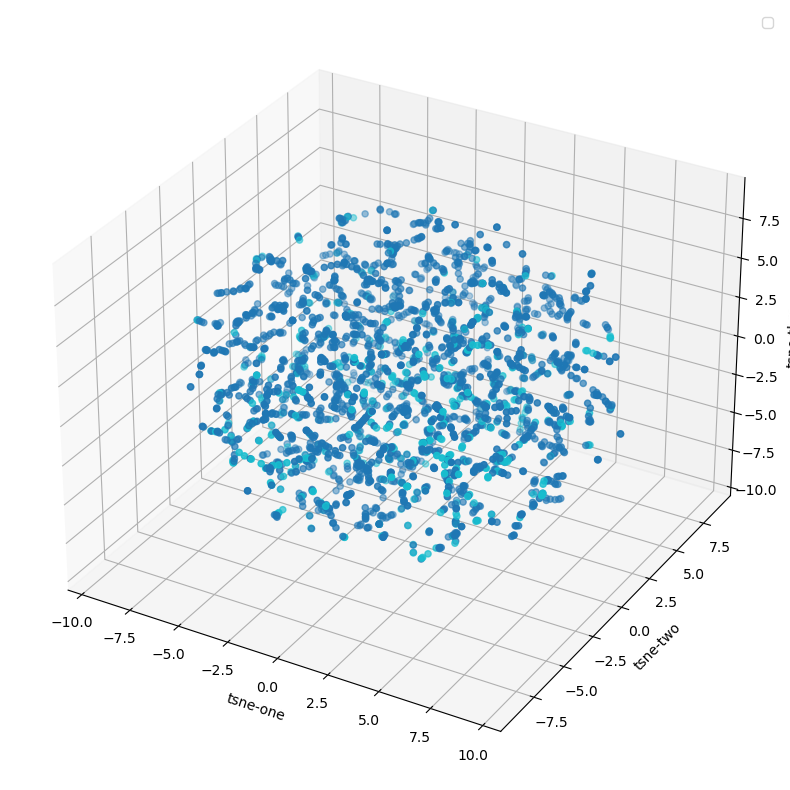

In [168]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca_result = pca.fit_transform(embeddings_train)

print('Explained variation per principal component: {}'.format([round(ele, 2) for ele in pca.explained_variance_ratio_]))
print(f'aka {round(sum(pca.explained_variance_ratio_), 3) * 100} %')


# 3d TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity = 2, n_iter=300)
tsne_results = tsne.fit_transform(np.array(pca_result))

one_dim = tsne_results[:,0]
two_dim = tsne_results[:,1]
three_dim = tsne_results[:,2]

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs = one_dim, 
    ys = two_dim, 
    zs = three_dim, 
    c = labels_train, 
    cmap='tab10'
)
ax.set_xlabel('tsne-one')
ax.set_ylabel('tsne-two')
ax.set_zlabel('tsne-three')
plt.legend()
plt.show()

#### XGBoost

In [164]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

x_model = XGBClassifier()

x_model.fit(embeddings_train, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [165]:
# on dev
y_pred = x_model.predict(embeddings_val)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(labels_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import classification_report
print(classification_report(predictions, labels_val))

Accuracy: 85.81%
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       406
           1       0.47      0.95      0.63        59

    accuracy                           0.86       465
   macro avg       0.73      0.90      0.77       465
weighted avg       0.93      0.86      0.88       465



In [166]:
# on test
y_pred = x_model.predict(embeddings_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import classification_report
print(classification_report(predictions, labels_test))

Accuracy: 88.39%
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1148
           1       0.49      0.92      0.64       144

    accuracy                           0.88      1292
   macro avg       0.74      0.90      0.79      1292
weighted avg       0.93      0.88      0.90      1292



## Test

In [15]:
from models.utils import compute_acc

test_model = history['final_model'].to(device)

test_model.eval()
test_accs = .0

tot_outputs = []
tot_pred = []

for inputs, labels in test_loader:
    for ele in inputs:
            inputs[ele] = inputs[ele].to(device)
    labels = labels.to(device)
    with torch.no_grad():
          outputs = test_model(
                inputs['input_ids'],
                inputs['attention_mask'],
            ).reshape(len(labels))
    test_accs += compute_acc(outputs, labels)
    tot_outputs.extend([int(x) for x in outputs.round().flatten().tolist()])
    tot_pred.extend([int(x) for x in labels.round().flatten().tolist()])

print(f'Final accuracy: {test_accs / len(test_loader)}')

Final accuracy: 1.0


In [17]:
from sklearn.metrics import classification_report

print(classification_report(tot_outputs, tot_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



## TODO
 - transfer learning su roberta (```require_grad = False``` on LM
)